In [1]:
import sys
import torch

sys.path.append("/workspace/kbqa/")  # go to parent dir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import datetime

now = datetime.datetime.now()
now

datetime.datetime(2024, 3, 18, 8, 42, 35, 590823)

#### Configuration

In the cell below, you can configure what type of training. For instance, you can choose what type of sequence to train catboost on (both, gap, or g2t); or what kind of dataset (either xl or large). The following options are valid:

* `finetune`: to whether do gridsearch on catboost, or just use default params
* `sequence_type`: choices=[both, gap, or g2t] where both means both gap and g2t as features
* `ds_type`: either T5-large-ssm or T5-xl-ssm. The graph features dataset (`features_ds_path`) and the seq2seq outputs dataset (`test_csv_path`) will be depended on the specified model from this argument.
* model_weights: None or the provided model weight, if None, train from scratch
* `save_path`: model weights, reranking results and features importance will be saved in this folder


In [26]:
from pathlib import Path

finetune = True
with_tdidf = False
num_iters = 100000
sequence_type = "all"
ds_type = "large"
test_csv_path = f"hle2000/Mintaka_T5_{ds_type}_ssm_outputs"
features_ds_path = f"s-nlp/Mintaka_Graph_Features_T5-{ds_type}-ssm"
model_weights = None
save_path = f"/workspace/storage/misc/features_reranking/{sequence_type}_tfidf_{with_tdidf}_{ds_type}/"
cache_path = "/workspace/storage/misc/huggingface"

In [27]:
from ast import literal_eval
import pandas as pd


def try_literal_eval(s):
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [28]:
import numpy as np


def arr_to_str(arr):
    arr = list(arr)
    return ",".join(str(a) for a in arr)


def str_to_arr(str):
    arr = str.split(",")
    arr = [float(a) for a in arr]
    return np.array(arr)

### Reading and Processing the Data

In [32]:
import pathlib
import shutil


def remove_cache():
    home_dir = pathlib.Path.home()
    dataset_dir = home_dir / ".cache" / "huggingface" / "datasets"

    shutil.rmtree(str(dataset_dir))


remove_cache()

In [30]:
from datasets import load_dataset

graph_features_ds = load_dataset(features_ds_path, cache_dir=cache_path)
processed_train_df = graph_features_ds["train"].to_pandas()
processed_test_df = graph_features_ds["test"].to_pandas()

Found cached dataset parquet (/workspace/storage/misc/huggingface/hle2000___parquet/hle2000--Mintaka_Graph_Features_Updated_T5-large-ssm-4e10b61230716f57/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
def get_numeric_cols(df):
    """return all cols with numeric features"""
    cols_numeric = []
    for k, v in df.dtypes.to_dict().items():
        if (v is np.dtype("int64") or v is np.dtype("float64")) and k != "correct":
            cols_numeric.append(k)

    return cols_numeric

In [11]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()


def apply_col_scale(df, col):
    """apply min max scaling"""
    df[col] = min_max_scaler.fit_transform(df[col])
    return df


# get the numerica cols in train and test to scale
train_numeric_cols = get_numeric_cols(processed_train_df)
test_numeric_cols = get_numeric_cols(processed_test_df)

processed_train_df = apply_col_scale(processed_train_df, train_numeric_cols)
processed_test_df = apply_col_scale(processed_test_df, test_numeric_cols)

In [12]:
def filter_df_sequence(dataframe, seq_type):
    """filter df base on the sequence type,
    return filtered df & textual + embedding features"""

    textual_feat = ["determ_sequence", "g2t_sequence", "gap_sequence"]
    if seq_type != "all":
        if seq_type == "g2t":
            rm_lst = ["determ_sequence", "gap_sequence"]
        elif seq_type == "determ":
            rm_lst = ["g2t_sequence", "gap_sequence"]
        elif seq_type == "gap":
            rm_lst = ["determ_sequence", "g2t_sequence"]
        drop_text_cols = [item for item in textual_feat if item in rm_lst]
        drop_em_cols = [f"{feat}_embedding" for feat in drop_text_cols]
        dataframe = dataframe.drop(drop_text_cols + drop_em_cols, axis=1)
        textual_feat = [f"{seq_type}_sequence"]
        emb_feat = [f"{seq_type}_sequence_embedding"]
    else:
        emb_feat = [f"{feat}_embedding" for feat in textual_feat]

    return dataframe, textual_feat, emb_feat

In [13]:
text_features = ["question_answer"]
emb_features = ["question_answer_embedding"]
processed_train_df, textual_feats, embd_feats = filter_df_sequence(
    processed_train_df, sequence_type
)
processed_test_df, _, _ = filter_df_sequence(processed_test_df, sequence_type)
text_features += textual_feats
emb_features += embd_feats

In [14]:
# make sure text features are str dtype
def process_text_features(df, text_features):
    for text_feat in text_features:
        df[text_feat] = df[text_feat].astype("string")
    return df


processed_train_df = process_text_features(processed_train_df, text_features)
processed_test_df = process_text_features(processed_test_df, text_features)

processed_train_df = processed_train_df.dropna()
processed_test_df = processed_test_df.dropna()

In [15]:
# dropping tfidf
if not with_tdidf:
    processed_train_df = processed_train_df.drop("tfidf_vector", axis=1)
    processed_test_df = processed_test_df.drop("tfidf_vector", axis=1)
else:  # with tfidf
    emb_features.append("tfidf_vector")

In [16]:
# turn str representation of embeddings back to np array
for e_f in emb_features:
    print(e_f)
    processed_train_df[e_f] = processed_train_df[e_f].apply(str_to_arr)
    processed_test_df[e_f] = processed_test_df[e_f].apply(str_to_arr)

question_answer_embedding
determ_sequence_embedding
g2t_sequence_embedding


In [17]:
drop_cols = ["correct", "question"]

X_train = processed_train_df.drop(drop_cols, axis=1)
y_train = processed_train_df["correct"].tolist()
X_test = processed_test_df.drop(drop_cols, axis=1)
y_test = processed_test_df["correct"].tolist()

In [18]:
import numpy as np


def find_weight(target):
    """find weight for imbalanced classification"""
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)]
    )
    weight = 1.0 / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in target])

    samples_weight = np.double(samples_weight)
    return samples_weight

#### Catboost

In [ ]:
from catboost import Pool, CatBoostRegressor

learn_pool = Pool(
    X_train,
    y_train,
    text_features=text_features,
    feature_names=list(X_train),
    embedding_features=emb_features,
    weight=find_weight(y_train),
)

test_pool = Pool(
    X_test,
    y_test,
    text_features=text_features,
    feature_names=list(X_test),
    embedding_features=emb_features,
    weight=find_weight(y_test),
)

#### Grid search

In [19]:
if finetune:
    print("finetuning")
    params = {
        "learning_rate": [0.03, 0.1],
        "depth": [4, 6, 10],
        "l2_leaf_reg": [5, 7, 9, 11],
    }
    model = CatBoostRegressor()
    grid_search_result = model.grid_search(params, learn_pool)

    lr = grid_search_result["params"]["learning_rate"]
    depth = grid_search_result["params"]["depth"]
    leaf = grid_search_result["params"]["l2_leaf_reg"]
else:
    lr = 0.1
    depth = 6
    leaf = 9

#### Fitting best params

In [20]:
if model_weights:  # eval
    print("loading model")
    model = CatBoostRegressor()  # parameters not required.
    model.load_model(model_weights)
else:  # train from scratch
    Path(save_path).mkdir(parents=True, exist_ok=True)
    print("training from scratch")
    model = CatBoostRegressor(
        iterations=num_iters,
        learning_rate=lr,
        depth=depth,
        l2_leaf_reg=leaf,
        # task_type="GPU",
        early_stopping_rounds=1000,
        eval_metric="RMSE",
    )

    model.fit(learn_pool, eval_set=test_pool, verbose=200)
    model.save_model(Path(save_path) / "best_model")
    print(f"model saved at {save_path}")

loading model


#### Reranking

In [21]:
from datasets import load_dataset

test_res_csv = load_dataset(
    test_csv_path, verification_mode="no_checks", cache_dir=cache_path
)["test"].to_pandas()

Found cached dataset parquet (/workspace/storage/misc/huggingface/hle2000___parquet/hle2000--Mintaka_T5_large_ssm_outputs-f31d696c971a731a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
from tqdm import tqdm

final_acc, top200_total, top1_total, seq2seq_correct = 0, 0, 0, 0

for idx, group in tqdm(test_res_csv.iterrows()):
    curr_question_df = processed_test_df[
        processed_test_df["question"] == group["question"]
    ]
    curr_question_df = curr_question_df.drop("question", axis=1)

    if (
        len(curr_question_df) == 0
    ):  # we don't have subgraph for this question, take answer from seq2seq
        if group["answer_0"] == group["target"]:
            seq2seq_correct += 1
        else:  # check if answer exist in 200 beams for question with no subgraphs
            all_beams = group.tolist()[2:-1]  # all 200 beams
            all_beams = set(all_beams)
            top200_total += 1 if group["target"] in all_beams else 0

    else:  # we have subgraph for this question
        all_beams = group.tolist()[2:-1]  # all 200 beams
        all_beams = set(all_beams)

        if group["target"] not in all_beams:  # no correct answer in beam
            continue

        # correct answer exist in beam
        top1_total += 1 if group["answer_0"] == group["target"] else 0
        top200_total += 1

        is_corrects = curr_question_df["correct"].astype(bool).tolist()
        curr_rows = curr_question_df.drop(["correct"], axis=1)

        preds = model.predict(curr_rows)
        max_idx = preds.argmax()

        if is_corrects[max_idx] is True:
            final_acc += 1


# final rerankinga, top1 and top200 result
reranking_res = (final_acc + seq2seq_correct) / len(test_res_csv)
top200 = (top200_total + seq2seq_correct) / len(test_res_csv)
top1 = (top1_total + seq2seq_correct) / len(test_res_csv)

with open(Path(save_path) / "reranking_results", "w+") as f:
    f.write(f"top1: {top1}, top200: {top200}, reranking top1: {reranking_res}")
print(f"top1: {top1}, top200: {top200}, reranking top1: {reranking_res}")

0it [00:00, ?it/s]

4000it [00:22, 179.63it/s]

top1: 0.25425, top200: 0.64375, reranking top1: 0.28775


#### Features Importance

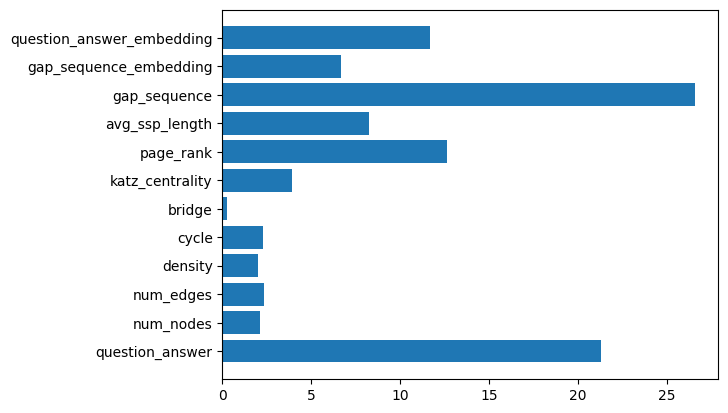

In [23]:
import matplotlib.pyplot as plt

col_names = X_test.columns.tolist()
features_importance = model.get_feature_importance(data=test_pool)

plt.barh(col_names, features_importance)
plt.savefig(Path(save_path) / "features_importance.png")
plt.show()